In [1]:
import os
import pickle
from tqdm import tqdm
from torchtext import data, datasets
from sklearn.model_selection import train_test_split

BATCH_SIZE = 10

with open("data/protein_sub_7.pickle", 'rb') as f:
    data_dict = pickle.load(f)

len(data_dict)

32283871

In [ ]:
data = list(data_dict.values())

In [12]:
sample = data[0]
sample

'SIGNLTELQKIDLHENWLKGLPESIGNLTELQILDLKWNNLRRLPNSFGNLSNLDSLDLRHNSLSTLPNSFSKLKKLPKTLNLTENSIDSLPLSLREMKLESLILVRNDINSFPKGITNLKELKSLDLYKN'

In [15]:
import numpy as np

temp = [len(d) for d in data]

np.mean(temp)

209.93062774287506

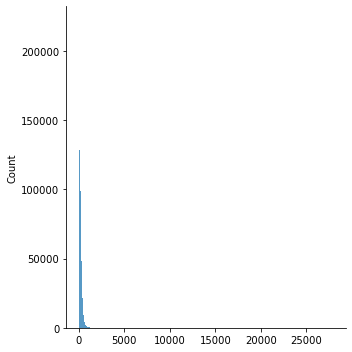

In [17]:
import seaborn as sns

sns.displot(temp)

In [18]:
import torch
import torchtext

SRC = torchtext.legacy.data.Field(tokenize=None,
                                init_token='<CLS>',
                                eos_token='<SEP>',
                                pad_token='<PAD>',
                                unk_token='<MASK>',
                                lower=False,
                                batch_first=False,
                                include_lengths=False)

SRC.build_vocab(data, min_freq=1)

In [19]:
SRC.preprocess(sample)

['SIGNLTELQKIDLHENWLKGLPESIGNLTELQILDLKWNNLRRLPNSFGNLSNLDSLDLRHNSLSTLPNSFSKLKKLPKTLNLTENSIDSLPLSLREMKLESLILVRNDINSFPKGITNLKELKSLDLYKN']

In [20]:
SRC.vocab.itos

['<MASK>',
 '<PAD>',
 '<CLS>',
 '<SEP>',
 'A',
 'L',
 'G',
 'V',
 'R',
 'E',
 'S',
 'I',
 'D',
 'T',
 'P',
 'K',
 'F',
 'N',
 'Q',
 'Y',
 'H',
 'M',
 'W',
 'C',
 'X',
 'B',
 'Z',
 'U']

In [21]:
class ProteinaceousLangaugeModelDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, seq_len=128, masking_rate=0.15):
        super(ProteinaceousLangaugeModelDataset, self).__init__()

        self.data          = data        
        self.tokenizer     = tokenizer
        self.vocab         = tokenizer.vocab
        self.seq_len       = seq_len
        self.masking_rate  = masking_rate
        
        self.cls_token_id  = self.tokenizer.vocab.stoi[self.tokenizer.init_token]
        self.sep_token_id  = self.tokenizer.vocab.stoi[self.tokenizer.eos_token]
        self.pad_token_id  = self.tokenizer.vocab.stoi[self.tokenizer.pad_token]
        self.mask_token_id = self.tokenizer.vocab.stoi[self.tokenizer.unk_token]
        
    def __getitem__(self, idx):
        target = self.tokenizer.numericalize(self.data[idx]).squeeze()
        
        if len(target) < self.seq_len - 2:
            pad_length = self.seq_len - len(target) - 2
        else:
            target = target[:self.seq_len-2]
            pad_length = 0
               
        masked_sent, masking_label = self.masking(target)
        
        # MLM
        train = torch.cat([
            torch.tensor([self.cls_token_id]), 
            masked_sent,
            torch.tensor([self.sep_token_id]),
            torch.tensor([self.pad_token_id] * pad_length)
        ]).long().contiguous()
        
        target = torch.cat([
            torch.tensor([self.cls_token_id]), 
            target,
            torch.tensor([self.sep_token_id]),
            torch.tensor([self.pad_token_id] * pad_length)
        ]).long().contiguous()
        
        masking_label = torch.cat([
            torch.zeros(1), 
            masking_label,
            torch.zeros(1),
            torch.zeros(pad_length)
        ])
                
        segment_embedding = torch.zeros(target.size(0))
        
        return train, target, segment_embedding, masking_label
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __iter__(self):
        for x in self.data:
            yield x
            
    
    def get_vocab(self):
        return self.vocab

    
    def masking(self, x):
        x             = torch.tensor(x).long().contiguous()
        masking_idx   = torch.randperm(x.size()[0])[:round(x.size()[0] * self.masking_rate) + 1]       
        masking_label = torch.zeros(x.size()[0])
        masking_label[masking_idx] = 1
        x             = x.masked_fill(masking_label.bool(), self.mask_token_id)
        
        return x, masking_label

In [22]:
dataset = ProteinaceousLangaugeModelDataset(data, SRC, seq_len=256, masking_rate=0.15)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

for train, target, sengment_embedding, masking_label in data_loader:
    print(train)
    print(target)
#     print(sengment_embedding)
#     print(masking_label)
    break

<ipython-input-21-e777c6d4f11b>:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x             = torch.tensor(x).long().contiguous()


tensor([[ 2, 19,  7,  ...,  1,  1,  1],
        [ 2, 13, 14,  ...,  1,  1,  1],
        [ 2,  7,  0,  ...,  1,  1,  1],
        ...,
        [ 2,  7,  8,  ...,  1,  1,  1],
        [ 2,  7, 12,  ...,  1,  1,  1],
        [ 2,  7, 19,  ...,  8,  7,  3]])
tensor([[ 2, 19,  7,  ...,  1,  1,  1],
        [ 2, 13, 14,  ...,  1,  1,  1],
        [ 2,  7,  8,  ...,  1,  1,  1],
        ...,
        [ 2,  7,  8,  ...,  1,  1,  1],
        [ 2,  7, 12,  ...,  1,  1,  1],
        [ 2,  7, 19,  ...,  8,  7,  3]])


In [23]:
def decode(x, tokenizer):
    results = []
    for line in x:
        decoded = ""
        for s in line:
            decoded += tokenizer.vocab.itos[s]
        results.append(decoded)
        
    return results

decode(target, SRC)

['<CLS>YVTTELAMEWAIQPADHQPSDWAQRLSYVRVFARHWHATDPRTEIPPDGLLPFRPQRARPYLYSEQEIQKLLAAALKLSPHQGLRPWTYHCLLGLLAVAGLRISEALKLERPDVDLHEGILTIRQTKFGKTRLVPLHQSARDVLADYARRRDRFLRNASSPSFFLNDHGRRLDGSAVRRTFYDLSRQIGLRRPEDRKGPRLHDFRHRFAVRTLV<SEP><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 '<CLS>TPASLAGALNNIAITEKQLGRYRAAEAHYRESLTLSRRTGSALNVARNLNNLGLLLLADGRPEEAQAILREGLELARSIDAKQVVPHLLGGLAKAALARGDNATARATADEAARLTEAAGARGSLVAAL<SEP><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>